# SIN(X) FFT
Two proccesses: 
-P1 encodes the input (sin(x)) to spikes
-P2 receives the spikes and implements DFT & FFT

In [42]:
#import modules

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import run_sft
import logging

In [43]:
#lava modules
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.model.sub.model import AbstractSubProcessModel
from lava.magma.core.process.ports.ports import InPort, OutPort
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.decorator import implements, requires, tag
from lava.magma.core.resources import CPU
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.process.variable import Var
from lava.proc.dense.process import Dense

#spikingFT modules
import spikingFT.models.snn
import spikingFT.utils.ft_utils

In [44]:
# Two Processes: one with an OutPort, one with an InPort
class P1(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        shape = kwargs.get("shape", (256,))
        bias = kwargs.pop("bias", 0)
        vth = kwargs.pop("vth", 10)
        
        self.shape = shape
        self.a_in = InPort(shape=shape)
        self.s_out = OutPort(shape=shape)
        self.w = Var(shape=shape, init=0)
        self.u = Var(shape=shape, init=0)
        self.v = Var(shape=shape, init=0)
        self.aux = Var(shape=shape, init=0)
        self.aux2 = Var(shape=shape, init=0)
        self.aux3 = Var(shape=shape, init=0)
        self.tspk = Var(shape=shape, init=0)
        self.k = Var(shape=shape, init=0)
        self.bias = Var(shape=shape, init=bias)
        self.vth = Var(shape=(1,), init=vth)
        self.s = Var(shape=(1,), init=0)

class P2(AbstractProcess):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        shape = kwargs.get('shape', (256,))
        self.inp2 = InPort(shape=shape)
        self.s_out2 = OutPort(shape=shape)
        self.aux3 = Var(shape=shape, init=0)
        self.v_membrane = Var(shape=shape, init=0)

        self.aux4 = Var(shape=shape, init=0)
        self.aux5 = Var(shape=shape, init=0)

        
#PyProcModel implementing P1
@implements(proc=P1, protocol=LoihiProtocol)
@requires(CPU)
@tag('floating_pt')
class PyLifModel1(PyLoihiProcessModel):
    a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float, precision=24)
    w: np.ndarray = LavaPyType(np.ndarray, float)
    u: np.ndarray = LavaPyType(np.ndarray, float)
    v: np.ndarray = LavaPyType(np.ndarray, float)
    aux: np.ndarray = LavaPyType(np.ndarray, float)
    aux2: np.ndarray = LavaPyType(np.ndarray, float)
    aux3: np.ndarray = LavaPyType(np.ndarray, float)
    bias: np.ndarray = LavaPyType(np.ndarray, float)
    tspk: np.ndarray = LavaPyType(np.ndarray, float)
    k: np.ndarray = LavaPyType(np.ndarray, float)
    vth: float = LavaPyType(float, float)
    s: np.ndarray = LavaPyType(np.ndarray, float)
    
    def run_spk(self):
        #sine function (from 0 to 2*pi; 256 samples)
        nsamples=256
        x = np.linspace(0, 2*np.pi, nsamples)
        plt.plot(x, np.sin(x))


        plt.xlabel('Angle [rad]')
        plt.ylabel('sin(x)')
        plt.axis('tight')
        plt.show()
        a_in_data=np.sin(x)
        self.u=a_in_data
        if(self.time_step==1):
            m=(1-num_steps_per_input)/(np.max(self.u)-np.min(self.u))
            b=1-m*np.max(self.u)
            '''
            print("m : ",m)
            print("b : ",b)
            '''
            for index2 in range(len(self.u)):
                self.tspk[index2] =m*self.u[index2]+b
                self.k[index2] = (vth/self.tspk[index2])-self.u[index2]
            '''
            print(self.tspk[:])
            print(self.k[:])
            '''
        for index in range(len(self.v)):
            if (self.aux[index]<1):
                self.v[index] += self.u[index]+self.k[index]

        s_out = self.v+0.00001 >= self.vth
        self.aux[:]+=s_out
        self.aux2[s_out]=self.time_step
        self.v[s_out] = 0  # Reset voltage to 0
        self.s_out.send(self.aux)


#PyProcModel implementing P2
@implements(proc=P2, protocol=LoihiProtocol)
@requires(CPU)
@tag('floating_pt')
class PyProcModelC(PyLoihiProcessModel):
    inp2: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    s_out2: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float, precision=24)
    aux3: np.ndarray = LavaPyType(np.ndarray, float)
    v_membrane: np.ndarray = LavaPyType(np.ndarray, float)
    aux4: np.ndarray = LavaPyType(np.ndarray, float)
    aux5: np.ndarray = LavaPyType(np.ndarray, float)


    def run_spk(self):
        in_data1 = self.inp2.recv()
        
        """
        Time step at which the threshold is reached by each neuron.
        """
        for index3 in range(len(in_data1)):
            #Adds +1 in case it spikes at time=0.
            if(self.time_step==1 and in_data1[index3]==1):
                self.aux3[index3]+=1
            #Keeps adding each time step if has not already spiked.
            if (in_data1[index3]<1):
                self.aux3[index3]=self.time_step


        if(self.time_step==num_steps_per_input):
            nsamples=256
            re_weights, im_weights = spikingFT.utils.ft_utils.dft_connection_matrix(
                nsamples,
                "numpy"
            )
            z_real = np.dot(re_weights, self.aux3.transpose())
            z_im = np.dot(im_weights, self.aux3.transpose())

            sft_real = z_real[1:int(nsamples/2)]
            sft_imag = z_im[1:int(nsamples/2)]
            sft_max = np.max(np.abs(np.hstack([sft_real, sft_imag])))

            sft_real = z_real / sft_max
            sft_imag = z_im / sft_max

            sft_modulus = np.sqrt(sft_real**2 + sft_imag**2)
            sft_modulus = np.log10(9*sft_modulus/sft_modulus.max()+1)



            #NUMPY FFT
            data = self.aux3
            print("Spiking times:\n{}".format(data))
            norm_data = data - data.min()
            norm_data /= norm_data.max()
            norm_data = (norm_data-0.5) * 2
            ft_np = np.fft.fft(norm_data) / (nsamples/2)
            ft_real = ft_np.real[1:int(nsamples/2)]
            ft_imag = ft_np.imag[1:int(nsamples/2)]
            ft_modulus = np.abs(ft_np)[1:int(nsamples/2)]

            #plotting both
            fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (30, 15))
            axes[0,0].plot(z_real[1:int(nsamples/2)])
            axes[0,0].set_ylabel("Real")
            axes[1,0].plot(z_im[1:int(nsamples/2)])
            axes[1,0].set_ylabel("Imag")
            axes[2,0].plot(sft_modulus[1:int(nsamples/2)])
            axes[2,0].set_ylabel("Modulus")
            axes[0,0].set_title("S-FT")

            axes[0,1].plot(ft_real)
            axes[1,1].plot(ft_imag)
            axes[2,1].plot(ft_modulus)
            axes[0,1].set_title("NumPy FFT")
            plt.show()


Containing process & model: where all the middle processes will be contained

In [45]:
class Combo(AbstractProcess):
    """Combines Dense and LIF Processes.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        shape = kwargs.get("shape", (256, ))
        self.s_in = InPort(shape=shape)
        self.s_out = OutPort(shape=shape)

In [46]:
@implements(proc=Combo, protocol=LoihiProtocol)
class ComboModel(AbstractSubProcessModel):

    def __init__(self, proc):
 
        self.p1 = P1()

        self.p2 = P2()


        # connect Parent in port to child Dense in port
        proc.in_ports.s_in.connect(self.p2.inp2)
        # connect Dense Proc out port to LIF Proc in port
        self.p2.s_out2.connect(proc.out_ports.s_out)


In [47]:
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps


Spiking times:
[50. 49. 48. 46. 45. 44. 43. 42. 40. 39. 38. 37. 36. 34. 33. 32. 31. 30.
 29. 28. 27. 26. 24. 23. 22. 21. 20. 19. 18. 18. 17. 16. 15. 14. 13. 12.
 12. 11. 10.  9.  9.  8.  7.  7.  6.  6.  5.  5.  4.  4.  3.  3.  3.  2.
  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  2.  2.  2.  2.  3.  3.  4.  4.  4.  5.  5.  6.  7.  7.  8.  8.  9. 10.
 10. 11. 12. 13. 14. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26.
 27. 28. 29. 30. 32. 33. 34. 35. 36. 37. 39. 40. 41. 42. 43. 45. 46. 47.
 48. 49. 51. 52. 53. 54. 55. 57. 58. 59. 60. 61. 63. 64. 65. 66. 67. 68.
 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 86.
 87. 88. 89. 90. 90. 91. 92. 92. 93. 93. 94. 95. 95. 96. 96. 96. 97. 97.
 98. 98. 98. 98. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 98. 98. 98. 97. 97. 97. 96. 96. 95. 95. 94. 94. 93. 93. 92. 91.
 91. 90. 89. 88. 88. 87. 86. 85. 84. 83. 82. 82. 81. 80. 79. 78. 77. 76.
 74. 73. 72. 71. 70. 69. 68. 67. 66.

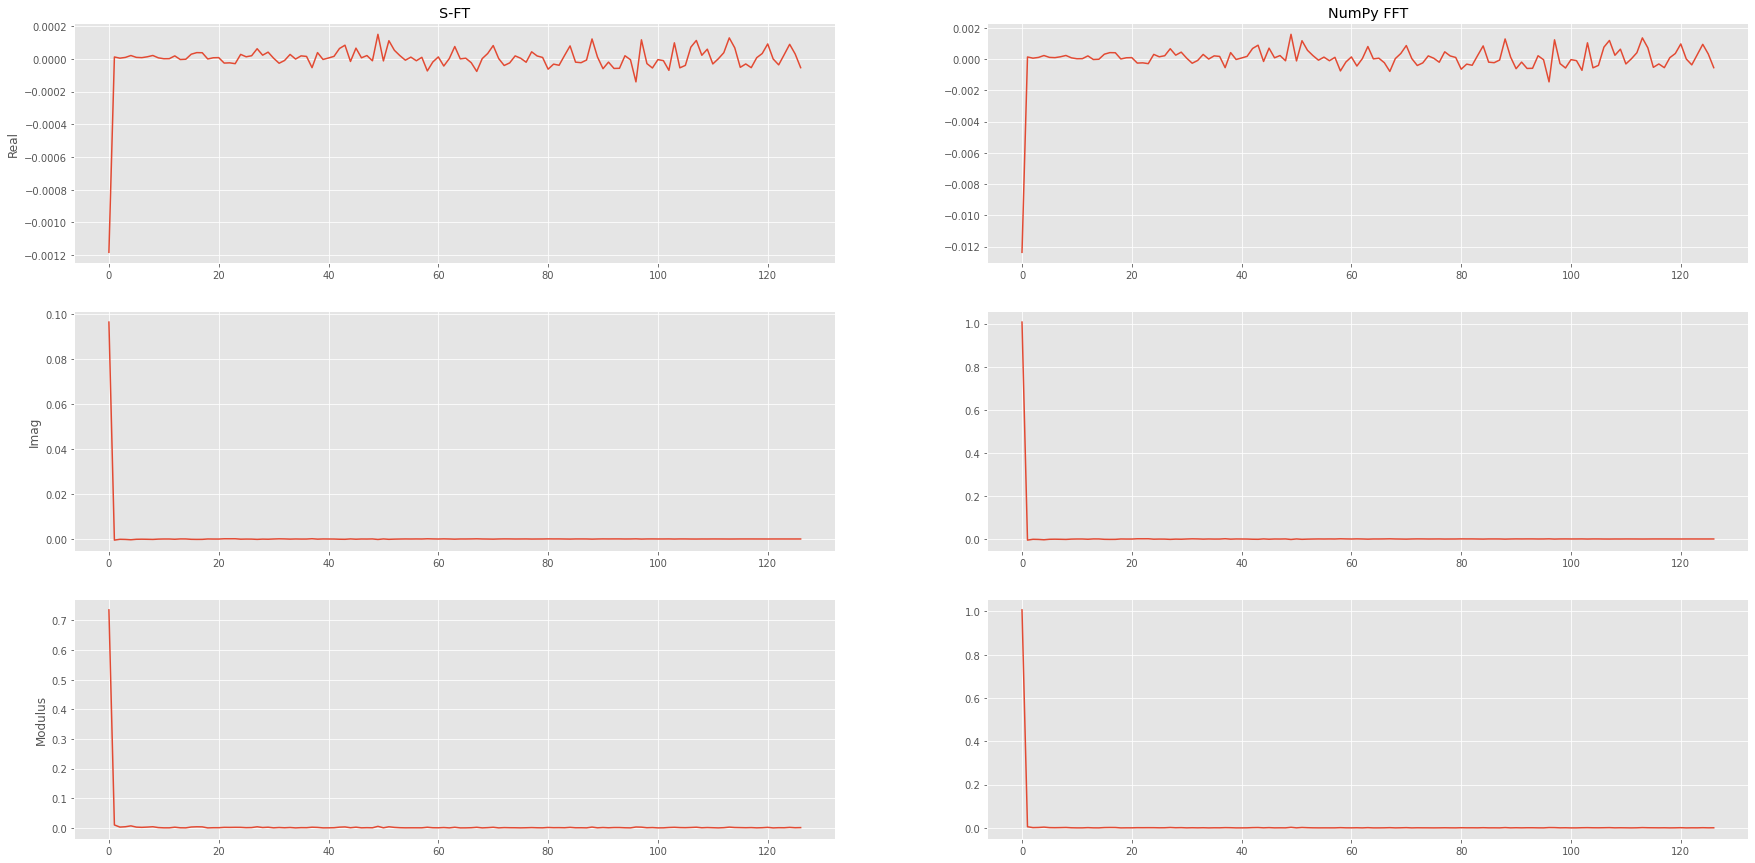

In [48]:
#Run the code

num_steps_per_input = 100
vth=10
step=1
lif = P1(shape=(256,), bias=0,num_steps=num_steps_per_input, threshold=vth)
sender2 = Combo()

# Connecting output port to an input port
lif.s_out.connect(sender2.s_in)


sender2.run(RunSteps(num_steps=num_steps_per_input), Loihi1SimCfg(select_tag='floating_pt', select_sub_proc_model=True))